In [1]:
from datetime import datetime
import itertools
import json
import math
import os
import time
import string

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import shapely.wkt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
try:
    from urllib.request import Request, urlopen  # Python 3
except:
    from urllib2 import Request, urlopen  # Python 2
TEST_ORIGIN = '530330001003'
BASKET_CATEGORIES = ["urban village", "citywide", "destination park", "supermarket", "library", 
              "hospital", "pharmacy", "post_office", "school", "cafe"]
BASKET_SIZE = 25
# Parameter domains
AA = [0,1,2,3,4] # urban village
BB = [8,9,10,11,12,13] # citywide destination
A = [0,1,2,3] # destination park
B = [0,1,2,3] # supermarket
C = [0,1,2,3] # library
D = [0,1,2,3] # hospital
E = [0,1,2,3] # pharmacy
F = [0,1,2,3] # post office
G = [0,1,2,3] # school
H = [0,1,2,3] # cafe
DEG_INTO_MILES = 69
CITY_CENTER = [47.6062, -122.3321]

In [29]:
def proximity_ratio(df_destinations):
    
    """
    Calculate proximity ratio and summarize by blockgroups
    input: 
        df_destination - data frame with distance, trip-level data
    output:
        df_blockgroup - data frame with origin blockgroup and proximity ratio
    """
    
    # proximity ratio = no. trips under 2 miles / no. trips between 2 and 10 miles; rows with zero denominators are removed
    df_destinations['dist_under_2'] = np.where(df_destinations['distance'] < 2.0, 1, 0)
    df_destinations['dist_2_to_10'] = np.where((df_destinations['distance'] >= 2.0) & (df_destinations['distance'] < 10.0), 1, 0)
    df_blockgroup = df_destinations.groupby(['origin'], as_index=False).agg({'dist_under_2':sum,'dist_2_to_10':sum})
    
    df_blockgroup = df_blockgroup[df_blockgroup['dist_2_to_10'] != 0]   
    df_blockgroup['proximity_ratio_test'] = df_blockgroup['dist_under_2'] / df_blockgroup['dist_2_to_10']
    """
    print((df_destinations.loc[df_destinations['origin'] == '530330048003']))
    print((df_destinations.loc[df_destinations['origin'] == '530330049002']))
    print((df_destinations.loc[df_destinations['origin'] == '530330049003']))    
    """
    return(df_blockgroup[['origin', 'proximity_ratio_test']])
    #return(df_blockgroup[['origin', 'proximity_ratio_test', 'dist_under_2', 'dist_2_to_10']])

In [30]:
def vert_hori_ratio(df_destinations, df_blockgroup):
    
    df_destinations['vertical_horizontal_ratio_test'] = pd.DataFrame(np.abs( (df_destinations['dest_lat'] - df_destinations['orig_lat']) / (df_destinations['dest_lon'] - df_destinations['orig_lon']) ))
    df_blockgroup2 = df_destinations.groupby(['origin'], as_index=False)['vertical_horizontal_ratio_test'].mean()
    result_merged = pd.merge(left=df_blockgroup, right=df_blockgroup2, how='inner', left_on='origin', right_on='origin')
    
    return(result_merged)

In [31]:
def average_distance(df_destinations, df_blockgroup):
    
    df_blockgroup2 = df_destinations.groupby(['origin'], as_index=False)['distance'].mean()
    result_merged = pd.merge(left=df_blockgroup, right=df_blockgroup2, how='inner', left_on='origin', right_on='origin')
    result_merged.rename(columns = {'distance': 'average_distance_test'}, inplace=True)
    
    return(result_merged)

In [32]:
"""paired = zip(df_destinations['dest_lat'],df_destinations['dest_lon'])
df_destinations = origin_merged.copy()
df_destinations.head()
np.sqrt(
    ((df_destinations['dest_lat'] - CITY_CENTER[0]) * DEG_INTO_MILES)**2 + 
    ((df_destinations['dest_lon'] - CITY_CENTER[1]) * DEG_INTO_MILES)**2
)"""

"paired = zip(df_destinations['dest_lat'],df_destinations['dest_lon'])\ndf_destinations = origin_merged.copy()\ndf_destinations.head()\nnp.sqrt(\n    ((df_destinations['dest_lat'] - CITY_CENTER[0]) * DEG_INTO_MILES)**2 + \n    ((df_destinations['dest_lon'] - CITY_CENTER[1]) * DEG_INTO_MILES)**2\n)"

In [33]:
def distance_from_citycenter(df_destinations, df_blockgroup):
   
    df_destinations['distance_from_citycenter_val'] = pd.DataFrame(np.sqrt(
                                                ((df_destinations['dest_lat'] - CITY_CENTER[0]) * DEG_INTO_MILES)**2 + 
                                                ((df_destinations['dest_lon'] - CITY_CENTER[1]) * DEG_INTO_MILES)**2
                                                ))
    
    df_blockgroup2 = df_destinations.groupby(['origin'], as_index=False)['distance_from_citycenter_val'].mean()
    result_merged = pd.merge(left=df_blockgroup, right=df_blockgroup2, how='inner', left_on='origin', right_on='origin')
    result_merged.rename(columns = {'distance_from_citycenter_val': 'distance_from_citycenter_test'}, inplace=True)
      
    return(result_merged)

In [34]:
"""
Next (Optional in case above three are not good enough) - Moran's I for x and y axes. 
Create weights by pairwise distance matrix for each blockgroup (inverse probability weighting by distance), 
and calculate Moran's I using python package
"""

"\nNext (Optional in case above three are not good enough) - Moran's I for x and y axes. \nCreate weights by pairwise distance matrix for each blockgroup (inverse probability weighting by distance), \nand calculate Moran's I using python package\n"

In [35]:
"""
If we have more time, we can try to compute spatial covariance matrix (might need to normalize the matrix)
and compare a. largest eigenvalues, b. traces, c. determinants.
However, there might be some issues with interpretation (meaning of the measures). 
Also we might need to parallelize the process as it is computationally expensive. 
"""

'\nIf we have more time, we can try to compute spatial covariance matrix (might need to normalize the matrix)\nand compare a. largest eigenvalues, b. traces, c. determinants.\nHowever, there might be some issues with interpretation (meaning of the measures). \nAlso we might need to parallelize the process as it is computationally expensive. \n'

In [36]:
def prepare_psrc(psrc_raw):
        
    # This will compute three features using PSRC data; just need to run it once
    psrc_blockgroup = proximity_ratio(psrc_raw)
    with_vert_hori_ratio = vert_hori_ratio(psrc_raw, psrc_blockgroup)
    with_average_distance = average_distance(psrc_raw, with_vert_hori_ratio)
    with_distance_from_citycenter = distance_from_citycenter(psrc_raw, with_average_distance)
    
    """
    # calculate weighted proximity ratio
    psrc_raw['dist_under_2'] = np.where(psrc_raw['distance'] < 2.0, 1, 0)
    psrc_raw['dist_2_to_10'] = np.where((psrc_raw['distance'] >= 2.0) & (psrc_raw['distance'] < 10.0), 1, 0)     
    psrc_raw['weighted_under_2'] = psrc_raw['weight'] * psrc_raw['dist_under_2']
    psrc_raw['weighted_2_to_10'] = psrc_raw['weight'] * psrc_raw['dist_2_to_10']    
    df_blockgroup2 = psrc_raw.groupby(['origin'], as_index=False).agg({'weighted_under_2':sum,'weighted_2_to_10':sum})
    df_blockgroup2['weighted_proximity_ratio'] = df_blockgroup2['weighted_under_2'] / df_blockgroup2['weighted_2_to_10']
    
    result_merged = pd.merge(left=with_distance_from_citycenter, right=df_blockgroup2, how='inner', left_on='origin', right_on='origin')
    result_merged.dropna(inplace=True)
    """
    result_merged = with_distance_from_citycenter
    result_merged.sort_values(by=['origin'])
    
    return (result_merged)    

In [37]:
def calculate_features(google_input, basket_combination):
    
    # This calculates three features using google API data; need to run separately for each basket combination
    
    # Filter to match basket parameters based on rank (distance from destination)
    filtered_data = google_input
    for i in range(len(BASKET_CATEGORIES)):
        filtered_data = filtered_data[(filtered_data['class'] != BASKET_CATEGORIES[i]) | (filtered_data['rank'] <= basket_combination[i])]
   
    # FEATURES: PROXIMITY RATIO, VERTICAL/HORIZONTAL TRAVEL DISTANCES, AVERAGE DISTANCE TO DESTINATION
    
    # Creating google results
    with_proximity_ratio = proximity_ratio(filtered_data.copy())
    with_vert_hori_ratio = vert_hori_ratio(filtered_data.copy(), with_proximity_ratio)
    with_average_distance = average_distance(filtered_data.copy(), with_vert_hori_ratio)
    with_distance_from_citycenter = distance_from_citycenter(filtered_data.copy(), with_average_distance)
    
    final_result = with_distance_from_citycenter.sort_values(by = ['origin'])
    
    return (final_result)

In [38]:
def draw_testplots(psrc_output, google_output):
    
    FEATURE_LIST = ['Proximity Ratio', 'Vertical/Horizontal', 'Average Distance', 'Distance From City Center']
    
    for i in range(4):
        plt.scatter(psrc_output.iloc[:,i+1], google_output.iloc[:,i+1])
        plt.xlabel('PSRC: ' + FEATURE_LIST[i], fontsize=15)
        plt.ylabel('Google API:' + FEATURE_LIST[i], fontsize=15)
        plt.xlim(min(psrc_output.iloc[:,i+1].min(), google_output.iloc[:,i+1].min()), 
                 max(psrc_output.iloc[:,i+1].max(), google_output.iloc[:,i+1].max())  * 1.1)
        plt.ylim(min(psrc_output.iloc[:,i+1].min(), google_output.iloc[:,i+1].min()), 
                 max(psrc_output.iloc[:,i+1].max(), google_output.iloc[:,i+1].max())  * 1.1)   
        plt.show()
    """ 
    plt.scatter(psrc_output.iloc[:,6], google_output.iloc[:,1])
    plt.xlabel('PSRC: Weighted Proximity Ratio', fontsize=15)
    plt.ylabel('Google API: Proximity Ratio', fontsize=15)
    plt.xlim(min(psrc_output.iloc[:,6].min(), google_output.iloc[:,1].min()), 
             max(psrc_output.iloc[:,6].max(), google_output.iloc[:,1].max()))
    plt.ylim(min(psrc_output.iloc[:,6].min(), google_output.iloc[:,1].min()), 
             max(psrc_output.iloc[:,6].max(), google_output.iloc[:,1].max())) 
    plt.show()
    """

In [39]:
"""print(df_google['distance_from_citycenter_test'].min(), df_google['distance_from_citycenter_test'].max())
print(googled_psrc['distance_from_citycenter_test'].min(), googled_psrc['distance_from_citycenter_test'].max())

#mean_squared_error(df_google['distance_from_citycenter_test'], googled_psrc['distance_from_citycenter_test'])

#print(len(df_google['distance_from_citycenter_test'].dropna()))
len(googled_psrc['distance_from_citycenter_test'].dropna())
len(df_google.dropna())
df_google.head()"""

"print(df_google['distance_from_citycenter_test'].min(), df_google['distance_from_citycenter_test'].max())\nprint(googled_psrc['distance_from_citycenter_test'].min(), googled_psrc['distance_from_citycenter_test'].max())\n\n#mean_squared_error(df_google['distance_from_citycenter_test'], googled_psrc['distance_from_citycenter_test'])\n\n#print(len(df_google['distance_from_citycenter_test'].dropna()))\nlen(googled_psrc['distance_from_citycenter_test'].dropna())\nlen(df_google.dropna())\ndf_google.head()"

In [40]:
"""df_google = calculate_features(origin_merged, testArray)
googled_psrc = df_psrc.loc[df_psrc['origin'].isin(df_google['origin'])]
#print(len(df_google), len(googled_psrc))
#print(googled_psrc)
print(df_google)
#distance_from_citycenter_mse = mean_squared_error(df_google['distance_from_citycenter_test'], googled_psrc['distance_from_citycenter_test'])


proximity_ratio_mse = mean_squared_error(df_google['proximity_ratio_test'], googled_psrc['proximity_ratio_test'])
print(len(df_google), len(googled_psrc))
vert_hori_ratio_mse = mean_squared_error(df_google['vertical_horizontal_ratio_test'], googled_psrc['vertical_horizontal_ratio_test'])
print(len(df_google), len(googled_psrc))
average_distance_mse = mean_squared_error(df_google['average_distance_test'], googled_psrc['average_distance_test'])
print(len(df_google), len(googled_psrc))


distance_from_citycenter_mse = mean_squared_error(df_google['distance_from_citycenter_test'], googled_psrc['distance_from_citycenter_test'])
print(len(df_google), len(googled_psrc))
"""

"df_google = calculate_features(origin_merged, testArray)\ngoogled_psrc = df_psrc.loc[df_psrc['origin'].isin(df_google['origin'])]\n#print(len(df_google), len(googled_psrc))\n#print(googled_psrc)\nprint(df_google)\n#distance_from_citycenter_mse = mean_squared_error(df_google['distance_from_citycenter_test'], googled_psrc['distance_from_citycenter_test'])\n\n\nproximity_ratio_mse = mean_squared_error(df_google['proximity_ratio_test'], googled_psrc['proximity_ratio_test'])\nprint(len(df_google), len(googled_psrc))\nvert_hori_ratio_mse = mean_squared_error(df_google['vertical_horizontal_ratio_test'], googled_psrc['vertical_horizontal_ratio_test'])\nprint(len(df_google), len(googled_psrc))\naverage_distance_mse = mean_squared_error(df_google['average_distance_test'], googled_psrc['average_distance_test'])\nprint(len(df_google), len(googled_psrc))\n\n\ndistance_from_citycenter_mse = mean_squared_error(df_google['distance_from_citycenter_test'], googled_psrc['distance_from_citycenter_test'])

In [41]:
def calculate_mse(psrc_output, google_input):

    score = []
    combinations = []

    for x in itertools.product(AA,BB,A,B,C,D,E,F,G,H):
        if (sum(x) == BASKET_SIZE):
            combinations.append(x)
            df_google = calculate_features(google_input, list(x))
            #df_google_result = df_google.sort_values(by=['origin'])
            googled_psrc = psrc_output.loc[psrc_output['origin'].isin(df_google['origin'])]
            #df_psrc_result = googled_psrc.sort_values(by=['origin'])
            proximity_ratio_mse = mean_squared_error(df_google['proximity_ratio_test'], googled_psrc['proximity_ratio_test'])
            vert_hori_ratio_mse = mean_squared_error(df_google['vertical_horizontal_ratio_test'], googled_psrc['vertical_horizontal_ratio_test'])
            average_distance_mse = mean_squared_error(df_google['average_distance_test'], googled_psrc['average_distance_test'])
            distance_from_citycenter_mse = mean_squared_error(df_google['distance_from_citycenter_test'], googled_psrc['distance_from_citycenter_test'])

            mses = (proximity_ratio_mse, vert_hori_ratio_mse, average_distance_mse, distance_from_citycenter_mse)
            #print("combination is :", x)
            score.append(mses)
            if (len(combinations) % 5000 == 0):
                print("Still Processing..")
                print("Idx+1 of combination is: ", len(combinations))

    print("Total number of combinations: " + str(len(combinations)))
    print()
    
    final_mses = pd.DataFrame(score, columns = ['from_proximity_ratio', 'from_vert_hori_ratio', 'from_average_distance', 'from_distance_citycenter'])
    final_mses['rank_from_proximity_ratio'] = final_mses['from_proximity_ratio'].rank(ascending=1)
    final_mses['rank_from_vert_hori_ratio'] = final_mses['from_vert_hori_ratio'].rank(ascending=1)
    final_mses['rank_from_average_distance'] = final_mses['from_average_distance'].rank(ascending=1)    
    final_mses['rank_from_distance_citycenter'] = final_mses['from_distance_citycenter'].rank(ascending=1)    
    
    
    final_combinations = pd.DataFrame(combinations, columns = BASKET_CATEGORIES)
    #print(final_combinations)
    
    best_loc = final_mses['rank_from_average_distance'].idxmin()
    print("Choose the following combination: \n")
    
    print("The index of the best basket is: ", best_loc)
    print(final_combinations.loc[best_loc])
    
    return(final_combinations, final_mses)

In [42]:
# Load PSRC data and pre-process; column names should be determined at a group meeting
psrc_rawdat = pd.read_csv("PSRC_full_final_july3.csv", dtype={'origin': str, 'destination': str})
"""psrc_rawdat['origin'] = '530330' + psrc_rawdat['o_bg']
psrc_rawdat['destination'] = '530330' + psrc_rawdat['d_bg']
psrc_orig_pts = psrc_rawdat['o_bg_lat_long'].apply(shapely.wkt.loads)
psrc_dest_pts = psrc_rawdat['d_bg_lat_long'].apply(shapely.wkt.loads)
psrc_rawdat['orig_lng'] = pd.DataFrame([kk.x for kk in psrc_orig_pts])
psrc_rawdat['orig_lat'] = pd.DataFrame([kk.y for kk in psrc_orig_pts])
psrc_rawdat['dest_lng'] = pd.DataFrame([kk.x for kk in psrc_dest_pts])
psrc_rawdat['dest_lat'] = pd.DataFrame([kk.y for kk in psrc_dest_pts])
psrc_rawdat.drop(columns = ['o_bg', 'o_bg_lat_long', 'd_bg', 'd_bg_lat_long'], inplace=True)
psrc_rawdat.rename(columns = {'trip_path_distance': 'distance', 'trip_weight_revised': 'weight'}, inplace=True)"""
psrc_rawdat['distance'] = pd.to_numeric(psrc_rawdat['distance'], errors='coerce')
psrc_rawdat.head()

,origin,orig_lon,orig_lat,distance,destination,weight,dest_lon,dest_lat
0,530330069001,-122.364974,47.637175,1.262005,530330059001,24.399908,-122.369693,47.653826
1,530330069001,-122.364974,47.637175,1.262005,530330059001,24.399908,-122.369693,47.653826
2,530330058014,-122.384216,47.655931,1.610594,530330059001,21.082019,-122.369693,47.653826
3,530330042001,-122.273223,47.672711,5.031864,530330059001,0.000000,-122.369693,47.653826
4,530330040001,-122.257869,47.681074,9.480882,530330059001,0.000000,-122.369693,47.653826


In [43]:
# Load Google API data 
# df_sample = pd.read_csv('Proximity_Ratio.csv', dtype={'bg_origin': str}) 
input_destinations = pd.read_csv('GoogleMatrix_Places_Dist.csv', dtype={'origin': str})
input_destinations.rename(columns = {'lat': 'dest_lat', 'lng': 'dest_lon', 'orig_lng': 'orig_lon'}, inplace=True)

In [44]:
# Load blockgroup data with latitude and longitudes; will be merged with Google API
blockgroup_mapping = pd.read_csv('SeattleCensusBlockGroups.csv', dtype={'tract_blkgrp': str})
blockgroup_mapping['tract_blkgrp'] = '530330' + blockgroup_mapping['tract_blkgrp']
orig_pts = blockgroup_mapping.centroid.apply(shapely.wkt.loads)
blockgroup_mapping['orig_lon'] = pd.DataFrame([kk.x for kk in orig_pts])
blockgroup_mapping['orig_lat'] = pd.DataFrame([kk.y for kk in orig_pts])
origin_blockgroups = blockgroup_mapping [['tract_blkgrp', 'orig_lat', 'orig_lon']]

In [45]:
# origin_merged will be an input data for 'evaluate_features' function
origin_merged = pd.merge(left=input_destinations, right=origin_blockgroups, how='left', left_on='origin', right_on='tract_blkgrp')
origin_merged = origin_merged[['origin', 'dest_lat', 'orig_lat','dest_lon', 'orig_lon', 'rank', 'distance', 'class']]

In [46]:
# One-time computation of psrc: generate three features
df_psrc = prepare_psrc(psrc_rawdat.copy())
df_psrc.head()

,origin,proximity_ratio_test,vertical_horizontal_ratio_test,average_distance_test,distance_from_citycenter_test
0,530330001001,0.666667,3.736674,5.789315,5.247427
1,530330001002,0.833333,2.603185,4.872482,8.675117
2,530330001003,4.545455,1.282848,1.798165,7.414976
3,530330001004,0.000000,0.701157,5.967649,6.235458
4,530330001005,1.111111,11.532798,2.178774,7.127926


In [47]:
"""
filtered_data = origin_merged
for i in range(len(BASKET_CATEGORIES)):
    filtered_data = filtered_data[(filtered_data['class'] != BASKET_CATEGORIES[i]) | (filtered_data['rank'] <= testArray[i])]
 
dd = proximity_ratio(filtered_data.copy())
print(dd[10:40])
"""

"\nfiltered_data = origin_merged\nfor i in range(len(BASKET_CATEGORIES)):\n    filtered_data = filtered_data[(filtered_data['class'] != BASKET_CATEGORIES[i]) | (filtered_data['rank'] <= testArray[i])]\n \ndd = proximity_ratio(filtered_data.copy())\nprint(dd[10:40])\n"

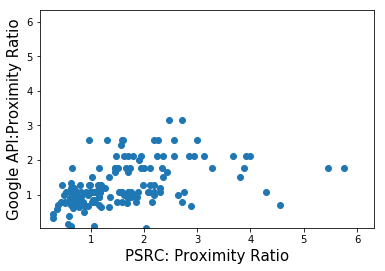

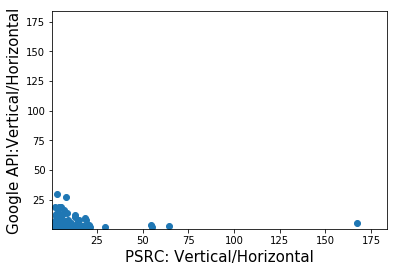

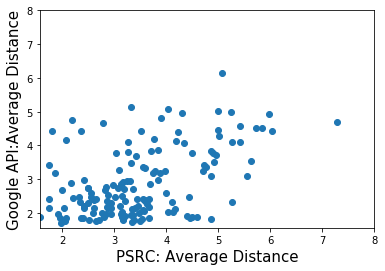

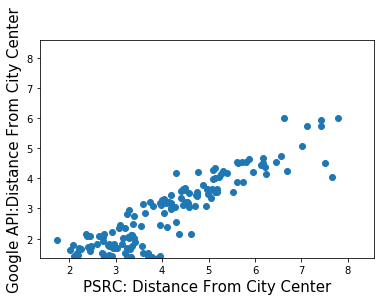

In [70]:
"""
You can play around here!
"""
#testArray = [3, 5, 2, 2, 2, 2, 3, 0, 1, 2]
#testArray = [0, 8, 0, 0, 0, 0, 0, 0, 0, 3]
#0	13	1	1	2	1	3	1	3	0	
#testArray = [1, 10, 2, 1, 3, 2, 1, 2, 1, 3]

## testArray = [1, 11, 1, 1, 2, 1, 3, 1, 3, 1]
testArray = [1, 13, 1, 1, 2, 1, 1, 1, 3, 1]
df_google = calculate_features(origin_merged, testArray)
googled_psrc = df_psrc.loc[df_psrc['origin'].isin(df_google['origin'])]
draw_testplots(googled_psrc, df_google)

#df_google.head()
#googled_psrc.head()

1.73946951692 7.78979661178


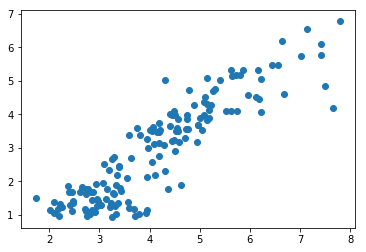

In [27]:
print(googled_psrc['distance_from_citycenter_test'].min(),
googled_psrc['distance_from_citycenter_test'].max())

plt.scatter(googled_psrc['distance_from_citycenter_test'], df_google['distance_from_citycenter_test'])
plt.show()

In [28]:
"""
plt.scatter(googled_psrc.iloc[:,7], df_google.iloc[:,1])
plt.xlabel('PSRC: Weighted Proximity Ratio', fontsize=15)
plt.ylabel('Google API: Proximity Ratio', fontsize=15)
plt.xlim(min(googled_psrc.iloc[:,7].min(), df_google.iloc[:,1].min()), 
         max(googled_psrc.iloc[:,7].max(), df_google.iloc[:,1].max()))
plt.ylim(min(googled_psrc.iloc[:,7].min(), df_google.iloc[:,1].min()), 
         max(googled_psrc.iloc[:,7].max(), df_google.iloc[:,1].max())) 
plt.show()
"""

"\nplt.scatter(googled_psrc.iloc[:,7], df_google.iloc[:,1])\nplt.xlabel('PSRC: Weighted Proximity Ratio', fontsize=15)\nplt.ylabel('Google API: Proximity Ratio', fontsize=15)\nplt.xlim(min(googled_psrc.iloc[:,7].min(), df_google.iloc[:,1].min()), \n         max(googled_psrc.iloc[:,7].max(), df_google.iloc[:,1].max()))\nplt.ylim(min(googled_psrc.iloc[:,7].min(), df_google.iloc[:,1].min()), \n         max(googled_psrc.iloc[:,7].max(), df_google.iloc[:,1].max())) \nplt.show()\n"

In [29]:
"""plt.scatter(googled_psrc['proximity_ratio_test'], df_google['proximity_ratio_test'])
plt.xlim(0, 6)
plta.ylim(0, 6)
plt.show()
"""

"plt.scatter(googled_psrc['proximity_ratio_test'], df_google['proximity_ratio_test'])\nplt.xlim(0, 6)\nplta.ylim(0, 6)\nplt.show()\n"

In [30]:
comb, res = calculate_mse(df_psrc, origin_merged.copy())
#res
comb.head()
res.head()

res.to_csv('Result/mses.csv')
comb.to_csv('Result/comb.csv')

Still Processing..
Idx+1 of combination is:  5000
Still Processing..
Idx+1 of combination is:  10000
Still Processing..
Idx+1 of combination is:  15000
Still Processing..
Idx+1 of combination is:  20000
Still Processing..
Idx+1 of combination is:  25000
Still Processing..
Idx+1 of combination is:  30000
Still Processing..
Idx+1 of combination is:  35000
Still Processing..
Idx+1 of combination is:  40000
Still Processing..
Idx+1 of combination is:  45000
Still Processing..
Idx+1 of combination is:  50000
Still Processing..
Idx+1 of combination is:  55000
Still Processing..
Idx+1 of combination is:  60000
Still Processing..
Idx+1 of combination is:  65000
Still Processing..
Idx+1 of combination is:  70000
Still Processing..
Idx+1 of combination is:  75000
Still Processing..
Idx+1 of combination is:  80000
Still Processing..
Idx+1 of combination is:  85000
Still Processing..
Idx+1 of combination is:  90000
Still Processing..
Idx+1 of combination is:  95000
Still Processing..
Idx+1 of comb

In [32]:
res.head()

,from_proximity_ratio,from_vert_hori_ratio,from_average_distance,from_distance_citycenter,rank_from_proximity_ratio,rank_from_vert_hori_ratio,rank_from_average_distance,rank_from_distance_citycenter
0,24.663486,288.912236,3.899003,2.127898,196506.0,124380.0,194200.0,184445.0
1,18.192179,290.007749,3.786381,2.062386,193736.0,135980.0,192023.0,152008.0
2,18.104726,288.997808,3.735689,2.084667,193690.0,125344.0,190915.0,166653.0
3,18.132287,289.218850,3.887547,2.016753,193704.0,127852.0,193989.0,110740.0
4,17.849943,290.518462,3.773708,2.106905,193664.0,141099.0,191760.0,177266.0


In [131]:
res = pd.read_csv('Result/mses.csv').iloc[:, 1:]
res.head()

,from_proximity_ratio,from_vert_hori_ratio,from_average_distance,from_distance_citycenter,rank_from_proximity_ratio,rank_from_vert_hori_ratio,rank_from_average_distance,rank_from_distance_citycenter
0,24.663486,288.912236,3.899003,2.127898,196506.0,124380.0,194200.0,184445.0
1,18.192179,290.007749,3.786381,2.062386,193736.0,135980.0,192023.0,152008.0
2,18.104726,288.997808,3.735689,2.084667,193690.0,125344.0,190915.0,166653.0
3,18.132287,289.218850,3.887547,2.016753,193704.0,127852.0,193989.0,110740.0
4,17.849943,290.518462,3.773708,2.106905,193664.0,141099.0,191760.0,177266.0


In [132]:
comb = pd.read_csv('Result/comb.csv').iloc[:, 1:]
comb.head()

,urban village,citywide,destination park,supermarket,library,hospital,pharmacy,post_office,school,cafe
0,0,8,0,0,2,3,3,3,3,3
1,0,8,0,0,3,2,3,3,3,3
2,0,8,0,0,3,3,2,3,3,3
3,0,8,0,0,3,3,3,2,3,3
4,0,8,0,0,3,3,3,3,2,3


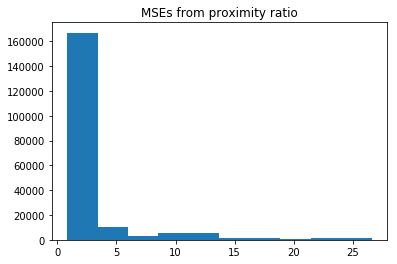

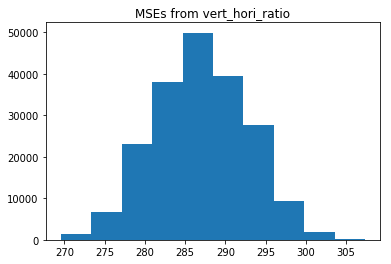

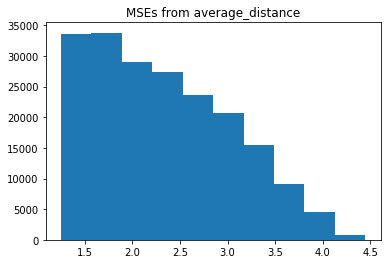

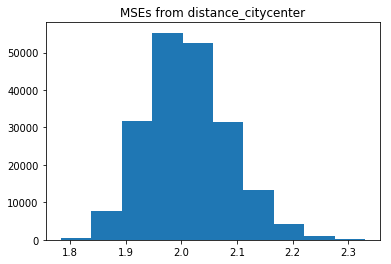

In [4]:
plt.hist(res['from_proximity_ratio'])
plt.title('MSEs from proximity ratio')
plt.show()

plt.hist(res['from_vert_hori_ratio'])
plt.title('MSEs from vert_hori_ratio')
plt.show()
plt.hist(res['from_average_distance'])
plt.title('MSEs from average_distance')
plt.show()
plt.hist(res['from_distance_citycenter'])
plt.title('MSEs from distance_citycenter')
plt.show()

In [133]:
res.columns

Index(['from_proximity_ratio', 'from_vert_hori_ratio', 'from_average_distance',
       'from_distance_citycenter', 'rank_from_proximity_ratio',
       'rank_from_vert_hori_ratio', 'rank_from_average_distance',
       'rank_from_distance_citycenter'],
      dtype='object')

In [134]:
comb['rank_pr'] = res['rank_from_proximity_ratio']
comb['rank_ad'] = res['rank_from_average_distance']
comb['rank_dc'] = res['rank_from_distance_citycenter']
comb['mse_pr'] = res['from_proximity_ratio']
comb['mse_ad'] = res['from_average_distance']
comb['mse_dc'] = res['from_distance_citycenter']

In [135]:
comb.loc[np.where(comb['rank_ad'] <= 5.0)]

,urban village,citywide,destination park,supermarket,library,hospital,pharmacy,post_office,school,cafe,rank_pr,rank_ad,rank_dc,mse_pr,mse_ad,mse_dc
33296,0,13,3,1,3,0,1,1,3,0,107367.0,1.0,39758.0,1.255168,1.249093,1.947139
33776,0,13,3,2,3,0,0,1,3,0,107070.0,2.0,55279.0,1.253337,1.251276,1.964049
33785,0,13,3,2,3,0,1,0,3,0,107101.0,5.0,30843.0,1.253573,1.254840,1.936071
34139,0,13,3,3,3,0,0,0,3,0,106793.0,3.0,39108.0,1.251626,1.251629,1.946413
72507,1,13,3,0,3,0,1,1,3,0,107305.0,4.0,51625.0,1.254770,1.253576,1.960237


In [18]:
comb.loc[np.where(comb['rank_dc'] <= 5.0)]

,urban village,citywide,destination park,supermarket,library,hospital,pharmacy,post_office,school,cafe,rank_pr,rank_ad,rank_dc
1599,0,8,3,1,3,1,3,0,3,3,136335.0,165814.0,1.0
1891,0,8,3,2,3,0,3,0,3,3,136732.0,166374.0,5.0
1921,0,8,3,2,3,1,3,0,3,2,136250.0,163557.0,4.0
36867,1,8,3,1,3,0,3,0,3,3,136883.0,167807.0,3.0
36897,1,8,3,1,3,1,3,0,3,2,136331.0,165030.0,2.0


In [78]:
comb.loc[np.where(comb['final_rank'] == 1.0)]

,urban village,citywide,destination park,supermarket,library,hospital,pharmacy,post_office,school,cafe,rank_pr,rank_ad,rank_dc,ranksum,final_rank
29926,0,13,1,3,2,0,3,0,3,0,22693.0,10214.0,813.0,33720.0,1.0


In [99]:
#comb.loc[np.where(comb['final_rank'] <= 50.0)]

In [136]:
comb['ranksum'] = comb['rank_pr'] + comb['rank_ad'] + comb['rank_dc']
#comb['msesum'] = res['from_proximity_ratio'] + res['from_average_distance'] + res['from_distance_citycenter']
comb['final_rank'] = comb['ranksum'].rank(ascending=1)
#comb['final_rank2'] = comb['msesum'].rank(ascending=1)
#for i in range(10):
#    print(comb.loc[np.where(comb['final_rank'] == i + 54.0)])
#comb[(comb['final_rank'] == 62.0) ]
#comb[(comb['final_rank2'] >= 57.0) & (comb['final_rank2'] <= 75.0) ]

In [139]:
FINAL_RANKS = [62, 159, 267, 54, 136, 290] # came up with discussion with team members
recommended_baskets = comb[comb['final_rank'].isin(FINAL_RANKS)]
recommended_baskets

,urban village,citywide,destination park,supermarket,library,hospital,pharmacy,post_office,school,cafe,rank_pr,rank_ad,rank_dc,mse_pr,mse_ad,mse_dc,ranksum,final_rank
29788,0,13,1,3,1,1,1,1,3,1,20296.0,17214.0,1415.0,0.914902,1.469791,1.856865,38925.0,62.0
67952,1,13,0,3,3,1,1,0,3,0,31269.0,11835.0,2833.0,0.938119,1.431066,1.869273,45937.0,267.0
68718,1,13,1,1,1,1,1,1,3,2,18847.0,24169.0,592.0,0.911852,1.513083,1.842323,43608.0,159.0
68888,1,13,1,1,2,1,1,1,3,1,20621.0,14739.0,3229.0,0.915610,1.453042,1.871910,38589.0,54.0
69333,1,13,1,2,1,1,1,1,3,1,20908.0,20570.0,1392.0,0.916190,1.491259,1.856576,42870.0,136.0
112119,2,13,1,1,1,1,1,1,3,1,22541.0,19580.0,4134.0,0.919717,1.485031,1.877049,46255.0,290.0


In [141]:
recommended_baskets.to_csv("Result/recommended_baskets.csv")

In [108]:
nonzero_comb = comb[(comb != 0).all(1)]
nonzero_comb['nonzero_rank'] = nonzero_comb['final_rank'].rank(ascending=1)
#nonzero_comb.loc[np.where(nonzero_comb['nonzero_rank'] <= 10.0)]
nonzero_comb[nonzero_comb['nonzero_rank'] <= 10.0]

/Users/woosubshin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,urban village,citywide,destination park,supermarket,library,hospital,pharmacy,post_office,school,cafe,rank_pr,rank_ad,rank_dc,ranksum,final_rank,msesum,final_rank2,nonzero_rank
68718,1,13,1,1,1,1,1,1,3,2,18847.0,24169.0,592.0,43608.0,159.0,4.267258,1142.0,3.0
68730,1,13,1,1,1,1,2,1,3,1,21661.0,21481.0,701.0,43843.0,167.0,4.259552,936.0,4.0
68743,1,13,1,1,1,1,3,1,2,1,21396.0,25823.0,2874.0,50093.0,706.5,4.309312,2702.0,7.0
68764,1,13,1,1,1,2,1,1,3,1,24821.0,21092.0,2540.0,48453.0,476.0,4.286625,1757.0,6.0
68887,1,13,1,1,2,1,1,1,2,2,17875.0,23193.0,11651.0,52719.0,1122.0,4.319592,3215.0,10.0
68888,1,13,1,1,2,1,1,1,3,1,20621.0,14739.0,3229.0,38589.0,54.0,4.240562,519.0,1.0
69333,1,13,1,2,1,1,1,1,3,1,20908.0,20570.0,1392.0,42870.0,136.0,4.264024,1045.0,2.0
69886,1,13,1,3,1,1,1,1,2,1,19198.0,24173.0,9091.0,52462.0,1071.0,4.321440,3306.0,9.0
70915,1,13,2,1,1,1,1,1,3,1,39499.0,6863.0,5185.0,51547.0,908.0,4.222035,239.0,8.0
112119,2,13,1,1,1,1,1,1,3,1,22541.0,19580.0,4134.0,46255.0,290.0,4.281796,1578.0,5.0


In [62]:
res.loc[np.where(res['rank_from_proximity_ratio'] <= 5.0)]

,from_proximity_ratio,from_vert_hori_ratio,from_average_distance,from_distance_citycenter,rank_from_proximity_ratio,rank_from_vert_hori_ratio,rank_from_average_distance,rank_from_distance_citycenter
11501,0.839129,282.913496,2.162821,1.898080,5.0,49719.0,91995.0,9920.0
11545,0.838535,278.289072,2.178026,1.878157,2.0,13210.0,93423.0,4356.0
16145,0.838441,277.585745,2.011403,1.901992,1.0,9974.0,79654.0,11354.0
49962,0.838710,277.171274,2.199697,1.881780,3.0,8386.0,95486.0,5109.0
55562,0.838752,276.476473,2.029382,1.905731,4.0,6152.0,81056.0,12925.0
